<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/1121_%ED%95%A9%EC%84%B1%EA%B3%B1%EC%8B%A0%EA%B2%BD%EB%A7%9D_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.2 합성곱 신경망 맛보기

fashion_mnist 데이터셋을 이용해 합성곱 신경망 직접 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('./data',  download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./data', download=True, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 232kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.9MB/s]


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100) # 데이터셋 지정, 데이터 배치로 묶음

# torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나
# 순서가 무작위로 섞이도록 할 수 있음

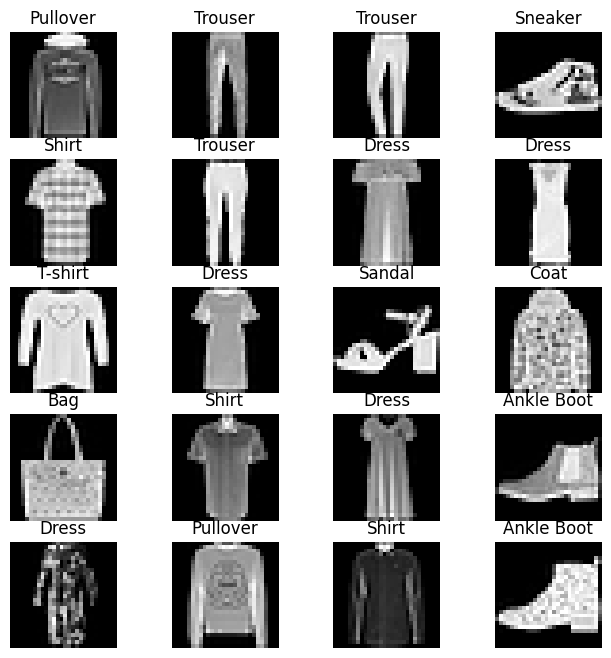

In [5]:
# 분류에 사용될 클래스 정의

labels_map = {0: 'T-shirt', 1: 'Trouser', 2: 'Pullover',
              3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker',
              8: 'Bag', 9: 'Ankle Boot'} # 열 개의 클래스

fig = plt.figure(figsize=(8, 8))
columns = 4;
rows = 5;
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

# 20개 이미지 데이터를 시각적으로 표현

np.random은 데이터를 무작위로 생성할 때 사용.

np.random.randint()는 이산형 분포를 갖는 데이터에서 무작위 표본 추출할 때 사용. 예시 코드에서는 0부터 데이터셋의 길이까지의 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라는 의미

- np.random.randint(10): 0부터 10까지 임의의 숫자 출력
- np.random.randint(1,10): 1~9까지 임의의 숫자 출력
- np.random.rand(8): 0~1 사이의 정규표준분포 난수를 행렬로 1x8 출력
- np.random.rand(4,2): 4x2 출력
- np.random.randn(8): 평균이 0이고 표준편차가 1인 가우시안 정규분포 난수를 행렬로 1x8 출력

examp - 6x4 행렬

- examp[3]: 네 번째 행에 해당하는 모든 요소값들을 출력
- examp[3,3]: 네 번째 행의 네 번째 열에 대한 값을 출력
- examp[3][3]: 위와 동일


In [6]:
# 심층 신경망 모델 생성

class FashionDNN(nn.Module): # class 형태 모델은 항상 torch.nn.Module 상속받음
  def __init__(self): # 객체가 갖는 속성 값 초기화 역할, 객체 생성 시 자동 호출
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

## 클래스와 함수

함수뿐만 아니라 관련된 변수까지도 한꺼번에 묶어서 관리하고 재사용할 수 있게 해 주는 것이 클래스.

- nn.Linear: nn 모듈로 단순 선형 회귀 모델 만들 때 사용
- in_features: 입력의 크기
- out_features: 출력의 크기
- forward() 함수는 모델이 학습 데이터를 입력받아서 순전파 학습을 진행시키며, 반드시 forward라는 이름의 함수여야 함.
- 활성화 함수를 지정할 때는 다음 두 가지 방법이 가능
1. F.relu(): forward() 함수에서 정의, nn.Sequential에 위치할 수 없음
2. nn.ReLU(): __init__() 함수에서 정의, nn.Sequential 내에 위치
> 이 둘의 차이는 간단하게는 사용 위치, 더 딥하게 nn은 input_channels, out_channels를 사용해서 연산하며, F는 입력과 가중치를 직접 넣어 줌.



In [7]:
# 심층 신경망에서 필요한 파라미터 정의

learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서의 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate); # 경사하강법 Adam 사용
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# 심층 신경망을 이용한 모델 학습

from numpy._core.defchararray import not_equal
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictons_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader: # 레코드에서 요소 두 개 꺼내 옴
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictons_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5884037017822266, Accuracy: 84.47333526611328%
Iteration: 1000, Loss: 0.4691201448440552, Accuracy: 85.41999816894531%
Iteration: 1500, Loss: 0.39952147006988525, Accuracy: 86.45833587646484%
Iteration: 2000, Loss: 0.4176398813724518, Accuracy: 87.43499755859375%
Iteration: 2500, Loss: 0.3090839982032776, Accuracy: 87.75166320800781%
Iteration: 3000, Loss: 0.29443854093551636, Accuracy: 88.52333068847656%


In [9]:
# 합성곱 네트워크 생성

class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential( # nn.Sequential 사용하여 가독성 향상
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 합성곱 연산으로 이미지 특징 추출
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

self.layer1 = nn.Sequential( # nn.Sequential 사용하여 가독성 향상
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 합성곱 연산으로 이미지 특징 추출
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)

- conv layer는 합성곱 연산을 통해서 이미지의 특징을 추출함. 합성곱은 커널 또는 필터라는 nxm 크기의 행렬이 높이x너비 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력함.
- in_channels : 입력 채널 개수 의미. 흑백 이미지는 1, 컬러는 주로 3. 이때 채널은 행렬 차원에서 볼 때 깊이로 이해 가능


In [10]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictons_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictons_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.46140778064727783, Accuracy: 89.20166778564453%
Iteration: 1000, Loss: 0.3294312655925751, Accuracy: 88.67833709716797%
Iteration: 1500, Loss: 0.3049292266368866, Accuracy: 90.3133316040039%
Iteration: 2000, Loss: 0.24684463441371918, Accuracy: 91.35832977294922%
Iteration: 2500, Loss: 0.15820184350013733, Accuracy: 91.50333404541016%
Iteration: 3000, Loss: 0.189930722117424, Accuracy: 92.66166687011719%
